In [17]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
import datetime
from datetime import timedelta

import seaborn as sns
from matplotlib import pyplot as plt

from fitter import Fitter

In [18]:
import datetime
from binance.client import Client

# from config import *
from toc import *
client = Client(t_key, t_secret)

In [20]:
depth = client.futures_coin_order_book(symbol='BTCUSD_PERP', pair="BTCBUSD")
depth

{'lastUpdateId': 214410314776,
 'E': 1632154434849,
 'T': 1632154434777,
 'symbol': 'BTCUSD_PERP',
 'pair': 'BTCUSD',
 'bids': [['43779.6', '10620'],
  ['43778.7', '164'],
  ['43778.6', '197'],
  ['43777.5', '144'],
  ['43776.7', '100'],
  ['43776.5', '2'],
  ['43776.2', '20'],
  ['43775.8', '86'],
  ['43775.7', '41'],
  ['43775.6', '31'],
  ['43775.4', '120'],
  ['43775.3', '190'],
  ['43774.4', '277'],
  ['43774.2', '1'],
  ['43774.1', '6'],
  ['43773.3', '50'],
  ['43773.2', '42'],
  ['43772.7', '40'],
  ['43772.6', '131'],
  ['43772.4', '2'],
  ['43772.0', '30'],
  ['43771.8', '82'],
  ['43771.7', '16'],
  ['43771.5', '28'],
  ['43770.9', '100'],
  ['43770.4', '742'],
  ['43769.8', '1'],
  ['43769.7', '40'],
  ['43769.5', '31'],
  ['43768.7', '1'],
  ['43768.0', '2'],
  ['43767.7', '10'],
  ['43767.4', '631'],
  ['43767.3', '340'],
  ['43767.1', '131'],
  ['43767.0', '50'],
  ['43766.6', '122'],
  ['43766.5', '31'],
  ['43766.2', '500'],
  ['43765.3', '11'],
  ['43764.9', '42'],
  

In [35]:
d = datetime.datetime.fromtimestamp(1632154434849/1e3)
d

datetime.datetime(2021, 9, 20, 11, 13, 54, 849000)

In [37]:
d.timestamp()

1632154434.849

In [30]:
datetime.datetime.fromtimestamp(1632154434849/1e3).ctime()

'Mon Sep 20 11:13:54 2021'

In [31]:
datetime.datetime.fromtimestamp(1632154434777/1e3).ctime()

'Mon Sep 20 11:13:54 2021'

In [3]:
def poly_ys(serie):
    x_axis = [i for i in range(len(serie))]
    models = []
    for i in range(2, 4):
        mymodel = np.poly1d(np.polyfit(x_axis, serie, i))
        models.append(mymodel)
    myline = np.linspace(1, len(serie), len(serie))
    y_s = []
#     data_max = argrelextrema(y, np.greater)[0]
#     data_min = argrelextrema(y, np.less)[0]
    for model in models:
        y_y = model(myline)
        y_s.append(y_y)
    return y_s

In [4]:
def d_xy(S, tipo):
    f = Fitter(S, distributions=[tipo])
    f.fit()
    dd = f.summary(Nbest=15).loc[tipo]['sumsquare_error']
    plt.close()
    return dd

In [5]:
def get_colio(serie):
    ys = poly_ys(serie)
    V = [serie]+ys
    corrs = []
    for v in range(len(V)):
        mini = []
        for w in range(len(V)):
            v_v = V[v]
            w_w = V[w]
            corr, _ = pearsonr(v_v, w_w)
            mini.append(corr)
        corrs.append(mini)
    arr_c = np.array(corrs)
    arr_c = arr_c[arr_c<0.9999999999999]

    dx = d_xy(serie, 'triang')
    dy = d_xy(ys[0], 'uniform')
    var = np.array([dx, dy]).std()
    
    me = ys[0]
    n = len(me)//2
    first, last = me[0], me[-1]
    middle = me[n]
    gansta = ''
    if middle>first or middle>last:
        gansta = 'up'
    else:
        gansta = 'down'
    
    U = arr_c.max(), arr_c.min(), arr_c.std(), np.std([arr_c.max(), arr_c.min()]), dx, dy, var, gansta #1 yes |3
    return U

In [6]:
def operative_decision(Z):
    maxi, mini, stdg, mixstd, leemis_x, leemis_y, gansta_var, eye = get_colio(Z)
    cs = .995, .8099, .07,   .1,     .00099999
    cs = .915, .723,  .0871, .10007, .00041661, .00078376, .00022995
    c1 = maxi>cs[0]
    c2 = mini>cs[1]
    c3 = stdg<cs[2]
    c4 = mixstd<cs[3]
    c5 = leemis_x<cs[4]
    c6 = leemis_y<cs[5]
    c7 = gansta_var<cs[6]
    stts = [maxi, mini, stdg, mixstd, leemis_x, leemis_y, gansta_var]
    decs = [c1, c2, c3, c4, c5, c6, c7]
    return stts, decs, eye # 15m \|/ 25 - 74

In [13]:
date = datetime.datetime.now() - timedelta(days=1)
date = date.strftime("%Y-%m-%d 00:00:00")
date

'2021-09-19 00:00:00'

177


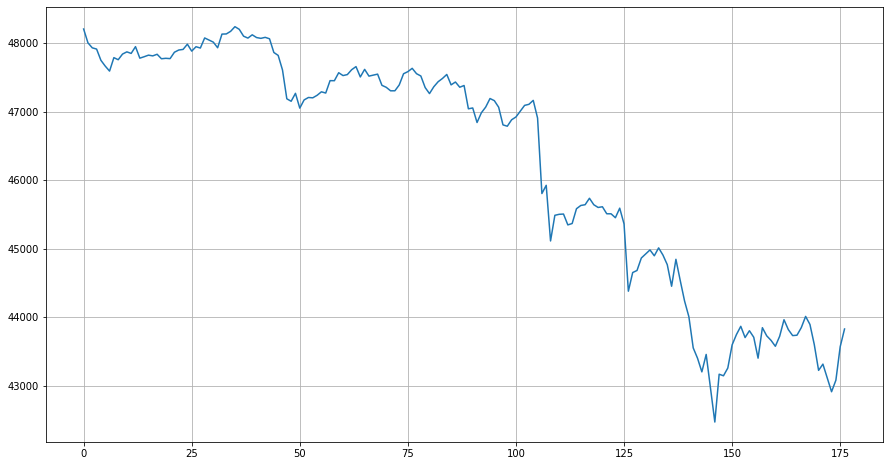

In [38]:
L3m = client.futures_historical_klines(symbol='BTCUSDT',
                      interval=client.KLINE_INTERVAL_15MINUTE,
                      start_str=date,
                      # start_str='2021-07-01 02:00:00',
                      # end_str='2021-07-07 02:00:00',
                      # start_str='2021-09-06 22:00:00',
                      # end_str='2021-09-12 09:00:00',
                      # end_str='2021-09-13 09:00:00',
                      #limit=1500
                                      )
print(len(L3m))
arr = np.array(L3m, dtype=np.float)
M3 = arr[:, 3]#[69:]
fig = plt.figure(figsize=(15, 8))
plt.plot(M3)
# plt.plot(M3, "x", c='b')
plt.grid()
plt.show()

48204.74 47983.0 0.4621220015422086 [False, False, False, False, False, False, False] 0.0 down
48002.73 47881.85 0.2524547401572927 [False, False, False, False, False, False, False] 0.0 down
47930.0 47946.15 0.03368362214693245 [True, False, False, False, False, False, False] 0.14285714285714285 down
47911.88 47927.0 0.03154797921840011 [True, False, False, False, False, False, False] 0.14285714285714285 up
47786.73 47931.0 0.30099518057206565 [True, True, False, False, False, False, False] 0.2857142857142857 up
47836.0 48068.4 0.4834777109285964 [True, True, True, True, False, False, False] 0.5714285714285714 up


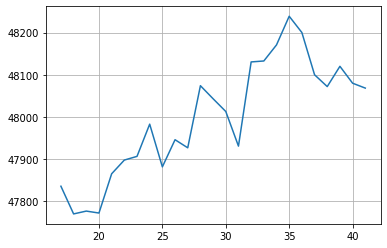

47772.5 47862.06 0.18712107251546983 [True, True, True, True, False, False, False] 0.5714285714285714 up


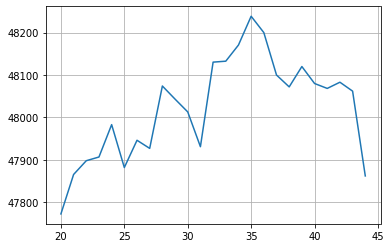

47865.47 47819.44 0.0962579235557732 [True, True, True, True, False, False, False] 0.5714285714285714 up


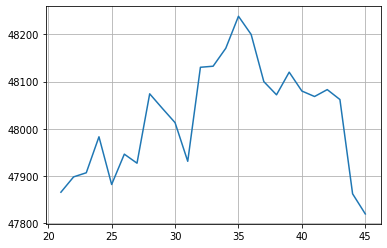

47186.03 47302.63 0.24649792199714593 [False, True, True, True, False, False, False] 0.42857142857142855 up
47150.1 47302.99 0.32321424079112004 [True, True, True, True, False, False, False] 0.5714285714285714 up


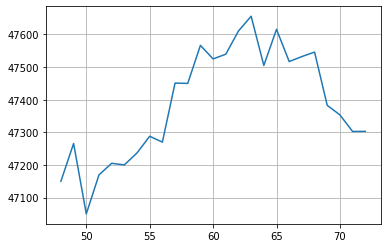

47265.86 47388.0 0.25774457668607964 [True, True, True, True, False, False, False] 0.5714285714285714 up


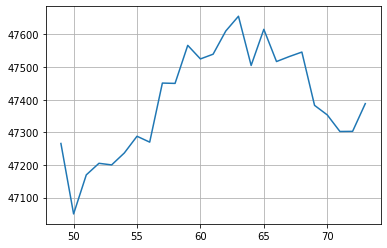

47288.0 47350.0 0.13093980992608237 [False, False, False, False, False, False, False] 0.0 up
47270.0 47262.01 0.016905755806826586 [False, False, False, False, False, False, False] 0.0 up
47451.0 47362.02 0.1878720544436306 [True, False, False, False, False, False, False] 0.14285714285714285 up
47450.0 47435.25 0.031095018999583644 [True, False, False, False, False, False, False] 0.14285714285714285 up
47566.6 47482.64 0.17682251871420615 [True, False, False, False, False, False, False] 0.14285714285714285 up
47525.0 47541.4 0.034496249584575665 [True, False, False, False, False, False, False] 0.14285714285714285 down
47539.5 47389.45 0.316631655357897 [True, False, False, False, False, False, False] 0.14285714285714285 down
47610.56 47431.0 0.37857097678732826 [False, False, False, False, False, False, False] 0.0 down
47505.0 47380.0 0.2638243984803714 [False, False, False, False, False, False, False] 0.0 up
47353.51 47190.0 0.34649290103835995 [True, True, False, True, False, False, 

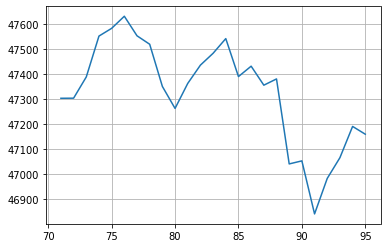

47262.01 47163.0 0.20993151411064193 [False, True, True, True, False, False, False] 0.42857142857142855 up
45111.0 44894.4 0.48246551908478236 [True, True, True, True, True, True, True] 1.0 up


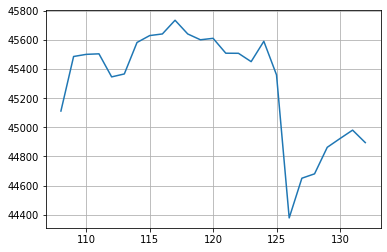

43550.17 43735.0 0.4226134674745667 [False, False, False, False, True, True, True] 0.42857142857142855 up
43165.78 43313.11 0.34015105357246744 [True, False, False, False, False, False, False] 0.14285714285714285 up
43143.0 43111.0 0.0742269954304006 [True, False, False, False, False, False, False] 0.14285714285714285 up
43744.75 43567.92 0.40587202694092755 [True, False, False, False, True, False, False] 0.2857142857142857 up


In [39]:
long = 25
ooc = 25
prc = []
indices = []
precios = []
fig = plt.figure(figsize=(12, 4))
for i in range(len(M3)-long):
    # print(i, end="|")
    # arr = M3[:]
    nn = i+long
    series = M3[i:nn]
    first = series[0]
    last = series[-1]
    # print(series)
    diff = 100*abs((first-last)/last)
    # print(first, last, diff)
    # if diff<=0.6:
    if diff<=0.5:
        _, yup, updo = operative_decision(series)
        avg = np.mean(yup)
        if avg>=0.5:
            print(first, last, diff, yup, avg, updo)
            plt.plot(list(range(i, nn)), series)
            plt.grid()
            plt.show()
            indices+=[i, nn]
            precios+=[first, last]
            prc.append(diff)
        else:
            print(first, last, diff, yup, avg, updo)
            # print(yup)
            pass
    # print(series.shape[0], end="|")
# plt.grid()
# plt.show()

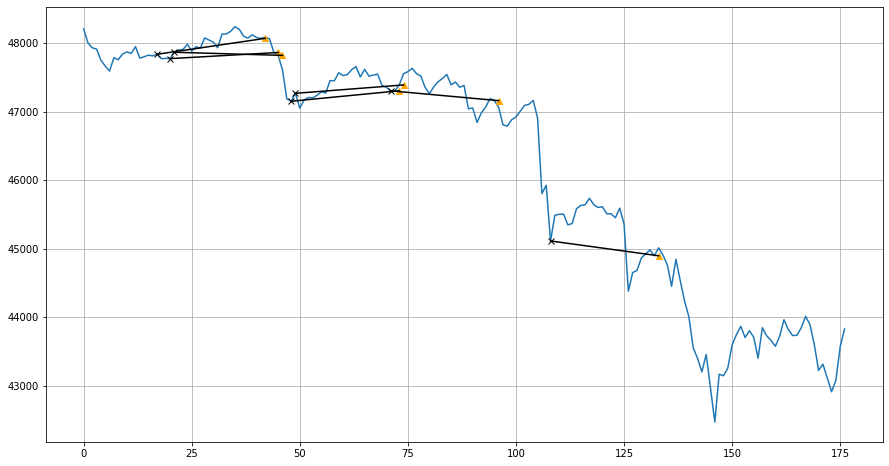

In [41]:
fig = plt.figure(figsize=(15, 8))
plt.plot(M3[:])
# for i in range(0, len(indices), 2):
for i in range(0, len(indices), 2):
    # plt.plot(indices[i+1], precios[i+1], "o")
    plt.plot(indices[i], precios[i], "x", c='k')
    plt.plot(indices[i+1], precios[i+1], "^", c='orange')
    plt.plot([indices[i], indices[i+1]], [precios[i], precios[i+1]], c='k')
    # plt.plot(, , c='r')
# plt.plot(M3, "x", c='b')
plt.grid()
plt.show()